# About

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from fancyimpute import mice
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeImputer, BiScaler

Using TensorFlow backend.


In [2]:
pd.set_option('display.float_format',lambda x:'%.4f'%x)

df_train_x = pd.read_csv('../data/train_values_6tLXv3T.csv', encoding='utf8')
df_test_x = pd.read_csv('../data/test_values_K7FqC54.csv', encoding='utf8')
df_train_y = pd.read_csv('../data/train_labels.csv', encoding='utf8')
df_test_y = pd.read_csv('../data/submission_format_klDJt5C.csv', encoding='utf8')

In [3]:
data_describe1 = pd.read_csv('train_x_describe.csv', index_col=0)
data_describe2 = pd.read_csv('test_x_describe.csv', index_col=0)

In [4]:
# combin df_train_x and df_train_y as df_train_all
df_train_all = pd.concat([df_train_x,df_train_y['prevalence_of_undernourishment']],axis=1)
df_train_all.shape

(1401, 47)

---  
# Cleaning Data: Trainning Data
--- 
### column 'droughts_floods_extreme_temps' fill with 0

In [5]:
df_train_all['droughts_floods_extreme_temps'] = df_train_all.droughts_floods_extreme_temps.fillna(0)

---   
### df_train_x drop columns if the missing value is over 40%

In [6]:
# df_train_all: 
data_describe1[data_describe1['null_rate']>0.4]

,duplicate,is_null,null_number,null_rate
droughts_floods_extreme_temps,76,True,1326,0.9465
inequality_index,430,True,972,0.6938
adult_literacy_rate,286,True,1116,0.7966
school_enrollment_rate_female,796,True,606,0.4325
rail_lines_density,450,True,944,0.6738


In [7]:
# df_test_x: 
data_describe2[data_describe2['null_rate']>0.4]

,duplicate,is_null,null_number,null_rate
droughts_floods_extreme_temps,35,True,582,0.9448
inequality_index,140,True,477,0.7744
tax_revenue_share_gdp,367,True,250,0.4058
adult_literacy_rate,108,True,509,0.8263
rail_lines_density,197,True,420,0.6818


In [8]:
# use training data to deside which columns should be drroped
drop_col = list(data_describe1[data_describe1['null_rate']>0.4].index)

In [9]:
df_train_all.drop(drop_col, axis=1, inplace=True)
df_train_all.shape

(1401, 42)

---  
### drop column 'country_code' 

In [10]:
df_train_all.drop(columns=['country_code'], inplace=True)

---  
### Deal with Outlier
* method1: 6 sigma   
    it may have problem, because the data may not be normal distribution

In [11]:
def filter_extreme_3sigma(df, tar_list, n=3):
    df_new = pd.DataFrame()
    for col in tar_list:
        col_mean = df[col].mean()
        col_std = df[col].std()
        max_range = col_mean + n*col_std
        min_range = col_mean - n*col_std
        df_new[col] = df[col].clip(min_range, max_range)
    return df_new

In [12]:
# df_filled_knn = filter_extreme_3sigma(df_filled_knn, list(df_filled_knn.columns), n=3)
# print(df_filled_knn.shape)

* method2: Tukey's Test   
    https://www.zhihu.com/question/38066650

In [13]:
def Tukey_test(df, tar_list, k=3):
    df_new = pd.DataFrame()
    for col in tar_list:
        q1 = np.percentile(df[col].values, 25)
        q3 = np.percentile(df[col].values, 75)
        IQR = q3 - q1
        max_range = q3 + k*IQR
        min_range = q1 - k*IQR
        df_new[col] = df[col].clip(min_range, max_range)
    return df_new

In [14]:
df_train_all = Tukey_test(df_train_all, list(df_train_all.columns), k=3)
print(df_train_all.shape)
df_train_all.columns

# column year can not get dummy before clear outliers. 0/1 do Tukey_test make no sence

(1401, 41)


c:\users\student\appdata\local\programs\python\python36\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Index(['row_id', 'year', 'agricultural_land_area',
       'percentage_of_arable_land_equipped_for_irrigation', 'cereal_yield',
       'forest_area', 'total_land_area', 'fertility_rate', 'life_expectancy',
       'rural_population', 'total_population', 'urban_population',
       'population_growth', 'avg_value_of_food_production',
       'cereal_import_dependency_ratio',
       'food_imports_as_share_of_merch_exports',
       'gross_domestic_product_per_capita_ppp',
       'imports_of_goods_and_services', 'net_oda_received_percent_gni',
       'net_oda_received_per_capita', 'tax_revenue_share_gdp',
       'trade_in_services', 'per_capita_food_production_variability',
       'per_capita_food_supply_variability', 'school_enrollment_rate_total',
       'avg_supply_of_protein_of_animal_origin',
       'caloric_energy_from_cereals_roots_tubers',
       'access_to_improved_sanitation', 'access_to_improved_water_sources',
       'anemia_prevalence', 'obesity_prevalence', 'open_defecation',
   

---   
### column 'year' do one-hot-encoding

c:\users\student\appdata\local\programs\python\python36\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


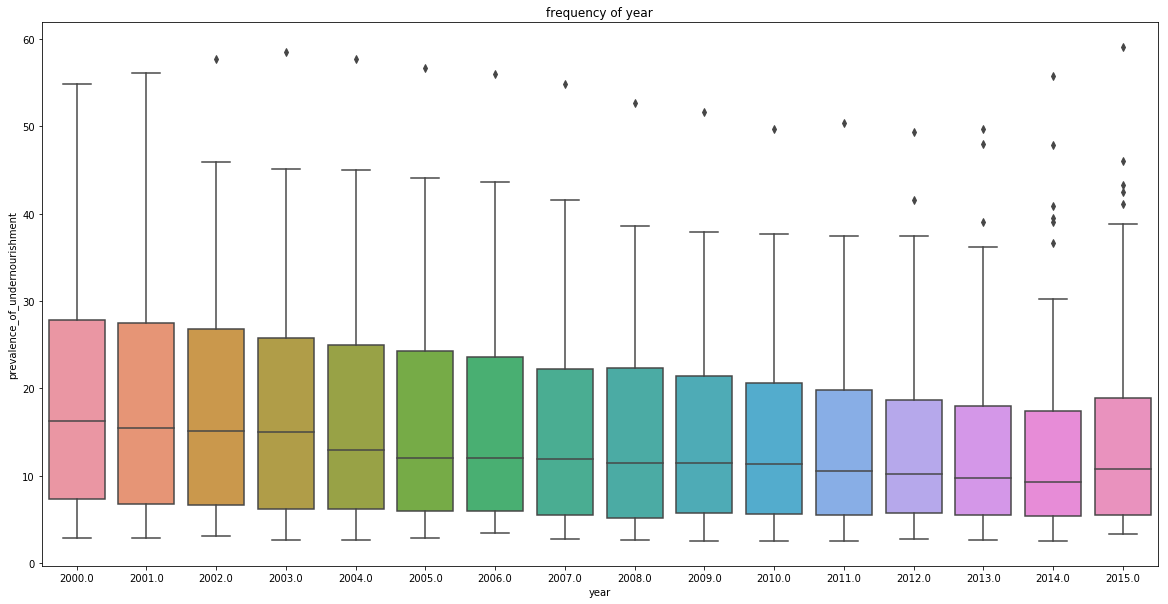

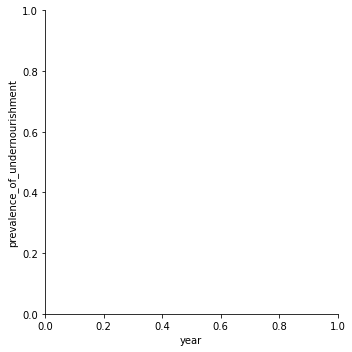

In [15]:
f, ax= plt.subplots(figsize = (20, 10));
sns.factorplot(x="year",y="prevalence_of_undernourishment", data=df_train_all, kind="box", ax=ax);
ax.set_title('frequency of year');

In [16]:
df_train_all.year = df_train_all.year.astype('int32', copy=False)
df_train_all = pd.get_dummies(data=df_train_all, columns=['year'], prefix='year')
print(df_train_all.shape)

(1401, 56)


In [17]:
df_test_x = pd.get_dummies(data=df_test_x, columns=['year'], prefix='year')

--- 
### export data for decision tree (not necessary, if you want to try)

In [18]:
def fill_knn(df):
    df_filled_knn =pd.DataFrame(KNN(k=5).fit_transform(df.as_matrix()))
    df_filled_knn.columns = df.columns
    df_filled_knn.index = df.index

    return df_filled_knn

# use KNN method to filled the null values
df_filled_knn_dt = fill_knn(df_train_all)
print('df_filled_knn_dt:', df_filled_knn_dt.shape, df_filled_knn_dt.isnull().any().any())

# export the data after process to csv as 'train_new.csv'
df_filled_knn_dt.to_csv('../data/train_dt.csv', encoding='utf8', index=False)

col_remain = list(df_filled_knn_dt.columns)

# drop the columns that train droped
col_remain.remove('prevalence_of_undernourishment')
df_test_x_dt = df_test_x[col_remain]

# use KNN method to filled the null values
df_test_filled_knn_dt = fill_knn(df_test_x_dt)

# check it has null number or not
print('df_test_filled_knn_dt:', df_test_filled_knn_dt.shape, df_test_filled_knn_dt.isnull().any().any())

# export the data after process to csv as 'train_new.csv'
df_test_filled_knn_dt.to_csv('../data/test_x_dt.csv', encoding='utf8', index=False)

c:\users\student\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Imputing row 1/1401 with 3 missing, elapsed time: 0.674
Imputing row 101/1401 with 0 missing, elapsed time: 0.681
Imputing row 201/1401 with 5 missing, elapsed time: 0.687
Imputing row 301/1401 with 0 missing, elapsed time: 0.693
Imputing row 401/1401 with 0 missing, elapsed time: 0.698
Imputing row 501/1401 with 1 missing, elapsed time: 0.705
Imputing row 601/1401 with 1 missing, elapsed time: 0.711
Imputing row 701/1401 with 2 missing, elapsed time: 0.717
Imputing row 801/1401 with 0 missing, elapsed time: 0.724
Imputing row 901/1401 with 1 missing, elapsed time: 0.729
Imputing row 1001/1401 with 4 missing, elapsed time: 0.735
Imputing row 1101/1401 with 2 missing, elapsed time: 0.741
Imputing row 1201/1401 with 2 missing, elapsed time: 0.748
Imputing row 1301/1401 with 18 missing, elapsed time: 0.753
Imputing row 1401/1401 with 0 missing, elapsed time: 0.758
df_filled_knn_dt: (1401, 56) False


c:\users\student\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Imputing row 1/616 with 3 missing, elapsed time: 0.139
Imputing row 101/616 with 1 missing, elapsed time: 0.145
Imputing row 201/616 with 0 missing, elapsed time: 0.150
Imputing row 301/616 with 1 missing, elapsed time: 0.155
Imputing row 401/616 with 12 missing, elapsed time: 0.160
Imputing row 501/616 with 1 missing, elapsed time: 0.164
Imputing row 601/616 with 10 missing, elapsed time: 0.169
df_test_filled_knn_dt: (616, 55) False


---   
### take out the columns that have less than 0.3 correlation (Spearman's correlation) with prevalence_of_undernourishment

* Pearson, Kendall and Spearman correlation's difference: 
    * http://blog.sina.com.cn/s/blog_548d137e0101874n.html
    * https://medium.com/@jockeyng/%E7%9B%B8%E9%97%9C%E6%80%A7correlation-pearson-kendall-spearman-5b638e8891ff
    * https://blog.csdn.net/wsywl/article/details/5889419

In [19]:
drop_list=[]
for i in df_train_all.columns[1:]:   # beside row_id and country_code
    if abs(df_train_all['prevalence_of_undernourishment'].corr(df_train_all[i], method = 'spearman')) < 0.35:
        drop_list.append(i)

df_train_all.drop(drop_list, axis = 1, inplace=True);
print(df_train_all.shape)
df_train_all.columns

(1401, 19)


Index(['row_id', 'fertility_rate', 'life_expectancy', 'population_growth',
       'avg_value_of_food_production', 'gross_domestic_product_per_capita_ppp',
       'net_oda_received_percent_gni',
       'per_capita_food_production_variability',
       'school_enrollment_rate_total',
       'avg_supply_of_protein_of_animal_origin',
       'caloric_energy_from_cereals_roots_tubers',
       'access_to_improved_sanitation', 'access_to_improved_water_sources',
       'anemia_prevalence', 'obesity_prevalence', 'open_defecation',
       'access_to_electricity', 'political_stability',
       'prevalence_of_undernourishment'],
      dtype='object')

--- 
### use KNN method to filled the null values 
    * other way can see: https://blog.csdn.net/Katherine_hsr/article/details/80279963  

In [20]:
# def fill_ii(df):
#     df_new=df.iloc[:,2:]
#     df_filled_ii = pd.DataFrame(IterativeImputer().fit_transform(df_new.as_matrix()))
#     df_filled_ii.columns = df_new.columns
#     df_filled_ii.index = df_new.index

#     return df_filled_ii

In [21]:
def fill_knn(df):
    df_filled_knn =pd.DataFrame(KNN(k=5).fit_transform(df.as_matrix()))
    df_filled_knn.columns = df.columns
    df_filled_knn.index = df.index

    return df_filled_knn

In [22]:
# use KNN method to filled the null values

df_filled_knn = fill_knn(df_train_all)
df_filled_knn.shape

c:\users\student\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Imputing row 1/1401 with 1 missing, elapsed time: 0.417
Imputing row 101/1401 with 0 missing, elapsed time: 0.420
Imputing row 201/1401 with 3 missing, elapsed time: 0.424
Imputing row 301/1401 with 0 missing, elapsed time: 0.426
Imputing row 401/1401 with 0 missing, elapsed time: 0.429
Imputing row 501/1401 with 0 missing, elapsed time: 0.432
Imputing row 601/1401 with 1 missing, elapsed time: 0.435
Imputing row 701/1401 with 1 missing, elapsed time: 0.438
Imputing row 801/1401 with 0 missing, elapsed time: 0.442
Imputing row 901/1401 with 0 missing, elapsed time: 0.444
Imputing row 1001/1401 with 0 missing, elapsed time: 0.447
Imputing row 1101/1401 with 1 missing, elapsed time: 0.450
Imputing row 1201/1401 with 1 missing, elapsed time: 0.453
Imputing row 1301/1401 with 6 missing, elapsed time: 0.456
Imputing row 1401/1401 with 0 missing, elapsed time: 0.459


(1401, 19)

In [23]:
# check it has null number or not
df_filled_knn.isnull().any().any()

False

In [24]:
# df_filled_knn[df_filled_knn.year_2006==1]

---  
### Spearman's correlation between left columns

In [25]:
corr_table = df_filled_knn.corr(method = 'spearman')
corr_table

,row_id,fertility_rate,life_expectancy,population_growth,avg_value_of_food_production,gross_domestic_product_per_capita_ppp,net_oda_received_percent_gni,per_capita_food_production_variability,school_enrollment_rate_total,avg_supply_of_protein_of_animal_origin,caloric_energy_from_cereals_roots_tubers,access_to_improved_sanitation,access_to_improved_water_sources,anemia_prevalence,obesity_prevalence,open_defecation,access_to_electricity,political_stability,prevalence_of_undernourishment
row_id,1.0000,-0.0215,0.0115,-0.0263,-0.0134,0.0267,-0.0417,0.0167,-0.0111,0.0004,0.0022,0.0300,0.0123,-0.0156,0.0167,-0.0372,0.0203,-0.0002,-0.0380
fertility_rate,-0.0215,1.0000,-0.7843,0.7355,-0.2231,-0.7548,0.4548,-0.1572,-0.5493,-0.6516,0.6109,-0.7299,-0.7529,0.6006,-0.5470,0.6636,-0.7625,-0.4012,0.5063
life_expectancy,0.0115,-0.7843,1.0000,-0.4543,0.1219,0.7624,-0.4201,0.0507,0.5550,0.6944,-0.6791,0.7990,0.7776,-0.6234,0.6132,-0.6508,0.7839,0.3931,-0.4943
population_growth,-0.0263,0.7355,-0.4543,1.0000,-0.3239,-0.4148,0.3155,-0.2065,-0.4292,-0.4353,0.4266,-0.4641,-0.4951,0.5054,-0.4338,0.4361,-0.4642,-0.2742,0.3613
avg_value_of_food_production,-0.0134,-0.2231,0.1219,-0.3239,1.0000,0.1538,-0.3008,0.5262,0.3376,0.1022,-0.1135,0.1120,0.1528,-0.3591,0.2436,-0.1492,0.2094,0.0310,-0.3626
gross_domestic_product_per_capita_ppp,0.0267,-0.7548,0.7624,-0.4148,0.1538,1.0000,-0.6420,0.1123,0.5540,0.7823,-0.7272,0.8030,0.7954,-0.5013,0.7433,-0.7045,0.8122,0.4607,-0.6511
net_oda_received_percent_gni,-0.0417,0.4548,-0.4201,0.3155,-0.3008,-0.6420,1.0000,-0.1028,-0.4114,-0.3994,0.3774,-0.3927,-0.4205,0.3084,-0.4445,0.3162,-0.4970,-0.0319,0.4373
per_capita_food_production_variability,0.0167,-0.1572,0.0507,-0.2065,0.5262,0.1123,-0.1028,1.0000,0.2386,0.1188,-0.1038,0.1580,0.1505,-0.2922,0.2658,-0.2065,0.1452,0.1857,-0.3137
school_enrollment_rate_total,-0.0111,-0.5493,0.5550,-0.4292,0.3376,0.5540,-0.4114,0.2386,1.0000,0.4961,-0.4625,0.5731,0.5194,-0.4885,0.4961,-0.4977,0.5708,0.2908,-0.4464
avg_supply_of_protein_of_animal_origin,0.0004,-0.6516,0.6944,-0.4353,0.1022,0.7823,-0.3994,0.1188,0.4961,1.0000,-0.8341,0.7345,0.7441,-0.4884,0.6581,-0.6583,0.7063,0.5203,-0.5898


Text(0.5, 1.0, 'Correlation between features')

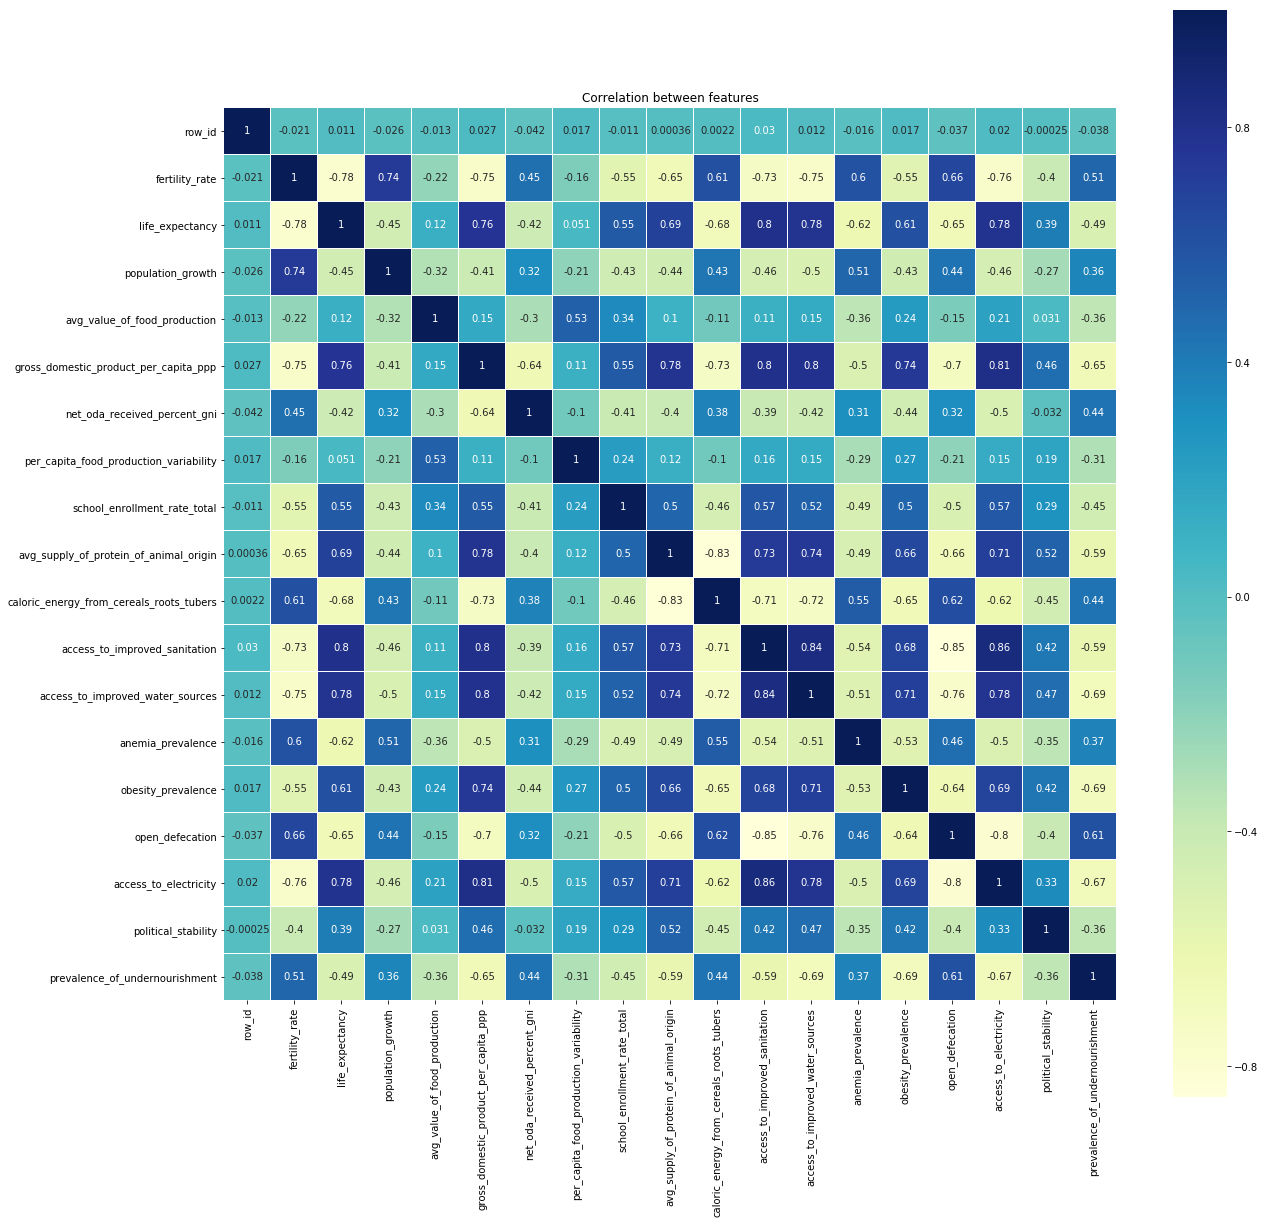

In [26]:
# Correlation between features

fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)

g=sns.heatmap(corr_table, vmax=1, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features')

---
### drop some columns to prevent the multicollinearity effect (corr > 0.7)

In [27]:
def multicollinearity_prevent(df, corr_method = 'spearman', level=0.7):
    corr_table = df.corr(method = corr_method)
    
    left_col = list(corr_table.index)
    drop_list = []

    for row in left_col:
        for col in  left_col:
            if corr_table[row][col] > level:
                drop_list.append([row, col])

    drop_col = []
    for pair_list in drop_list:
        if pair_list[0] == pair_list[1]:     # skip diagonal, because it always be 1
            pass
        else: 
            corr_A = corr_table['prevalence_of_undernourishment'][pair_list[0]]
            corr_B = corr_table['prevalence_of_undernourishment'][pair_list[1]]
            if corr_A > corr_B: drop_col.append(pair_list[0])
            else: drop_col.append(pair_list[1])

    return df.drop(columns=set(drop_col))


In [28]:
multicollinearity_prevent(df_filled_knn, 'spearman', 0.7);

In [29]:
col_remain = list(df_filled_knn.columns)
print(df_filled_knn.shape)
col_remain

(1401, 19)


['row_id',
 'fertility_rate',
 'life_expectancy',
 'population_growth',
 'avg_value_of_food_production',
 'gross_domestic_product_per_capita_ppp',
 'net_oda_received_percent_gni',
 'per_capita_food_production_variability',
 'school_enrollment_rate_total',
 'avg_supply_of_protein_of_animal_origin',
 'caloric_energy_from_cereals_roots_tubers',
 'access_to_improved_sanitation',
 'access_to_improved_water_sources',
 'anemia_prevalence',
 'obesity_prevalence',
 'open_defecation',
 'access_to_electricity',
 'political_stability',
 'prevalence_of_undernourishment']

In [30]:
# export the data after process to csv as 'train_new.csv'
df_filled_knn.to_csv('../data/train_new.csv', encoding='utf8', index=False)

---  
# Cleaning Data: Test Data
--- 

In [31]:
# drop the columns that train droped

col_remain.remove('prevalence_of_undernourishment')
df_test_x = df_test_x[col_remain]
df_test_x.shape

(616, 18)

In [32]:
# use KNN method to filled the null values

df_test_filled_knn = fill_knn(df_test_x)
df_test_filled_knn.shape

Imputing row 1/616 with 1 missing, elapsed time: 0.075
Imputing row 101/616 with 0 missing, elapsed time: 0.077
Imputing row 201/616 with 0 missing, elapsed time: 0.079
Imputing row 301/616 with 1 missing, elapsed time: 0.081
Imputing row 401/616 with 6 missing, elapsed time: 0.084
Imputing row 501/616 with 0 missing, elapsed time: 0.086
Imputing row 601/616 with 5 missing, elapsed time: 0.088


c:\users\student\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


(616, 18)

In [33]:
# check it has null number or not
df_test_filled_knn.isnull().any().any()

False

In [34]:
# export the data after process to csv as 'train_new.csv'
df_test_filled_knn.to_csv('../data/test_x_new.csv', encoding='utf8', index=False)

--- 
# Summary